**Importing Libraries and Setting Up Notebook**

In [ ]:
!nvidia-smi

Sun Jan 17 07:26:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 8.6MB/s 
     |████████████████████████████████| 2.9MB 52.0MB/s 
     |████████████████████████████████| 890kB 57.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2e5c6cef3b11b7fbc16c3ecea1bf5318cbeec958436872293e4fe5c2c88223e3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 8.2MB/s 


In [ ]:
import torch
import json
import pandas as pd
from tqdm import tqdm
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

In [ ]:
print(torch.__version__)
print(transformers.__version__)

1.7.0+cu101
4.2.1


**Importing Source Data**

In [ ]:
pwd

'/content'

In [ ]:
data_src  = pd.read_pickle("/content/drive/MyDrive/Data/stockpredict/nlpbase_id20201219.pkl")
print(data_src.shape)
data_src.head(3)

(68840, 27)


,Date,Open,High,Low,Close,Adj Close,Volume,Day,close_d1,close_d2,close_d3,close_d4,change_d1,change_d2,change_d3,change_d4,target_d1,target_d2,target_d3,target_d4,input_day,Published_Dates,Headlines,Articles,ByLines,Portal,Sections
0,2019-01-07,1107.000000,1118.449951,1101.0,1104.750000,1094.612793,5513559.0,Monday,1104.650024,1110.75,1107.500000,1098.050049,-0.099976,6.000000,2.750000,-6.699951,0.0,1.0,1.0,0.0,0,2019-01-07,Jio continues to capture market share; Vodafon...,The entry of Reliance Jio Infocomm (Jio) had t...,Moneycontrol.com,MoneyControl,NaN
1,2019-01-07,1107.000000,1118.449951,1101.0,1104.750000,1094.612793,5513559.0,Monday,1104.650024,1110.75,1107.500000,1098.050049,-0.099976,6.000000,2.750000,-6.699951,0.0,1.0,1.0,0.0,0,2019-01-07,RIL gains nearly 2% after CLSA maintains buy r...,Global brokerage house CLSA has maintained buy...,Moneycontrol.com,MoneyControl,NaN
2,2019-01-08,1105.099976,1109.949951,1096.0,1104.650024,1094.513794,5625153.0,Tuesday,1110.750000,1107.50,1098.050049,1096.800049,6.099976,2.849976,-6.599975,-7.849975,1.0,1.0,0.0,0.0,1,2019-01-07,Jio continues to capture market share; Vodafon...,The entry of Reliance Jio Infocomm (Jio) had t...,Moneycontrol.com,MoneyControl,NaN


In [ ]:
print(data_src.iloc[0]['Headlines'])
print(data_src.iloc[0]['Articles'])

Jio continues to capture market share; Vodafone-Idea cedes ground
The entry of Reliance Jio Infocomm (Jio) had turned the tables in the Indian telecommunication space. Jio’s freebies intensified the price war leading to consolidation in the industry and elimination of marginal players. Big players faced the heat due to a steady decline in Average Revenue Per User (ARPU) and found it difficult to maintain their market share as Jio’s competitive pricing helped it dd new customers. This trend continues and was visible in the latest subscriber addition numbers reported by Telecom Regulatory Authority of India (TRAI)..For more research articles, visit our Moneycontrol Research page


In [ ]:
data_src['num_words'] = data_src['Articles'].apply(lambda x : len(x.split()))

In [ ]:
data_src['num_words'].describe()

count    68840.000000
mean       313.946107
std        306.230044
min          0.000000
25%        191.000000
50%        260.000000
75%        366.000000
max      10698.000000
Name: num_words, dtype: float64

In [ ]:
print(len(data_src[data_src['num_words'] >= 1000]))
print(len(data_src[data_src['num_words'] > 512]))
print(len(data_src[data_src['num_words'] == 0]))

833
7565
193


In [ ]:
data_src[data_src['num_words'] == 0]['Portal'].value_counts()

MoneyControl    193
Name: Portal, dtype: int64

In [ ]:
data_src[data_src['num_words'] > 512]['Portal'].value_counts()

MoneyControl    5299
TheHindu        2266
Name: Portal, dtype: int64

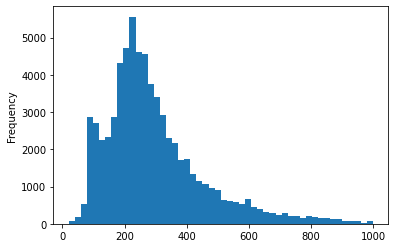

In [ ]:
data_src[(data_src['num_words'] != 0) & (data_src['num_words'] < 1000)]['num_words'].plot.hist(bins=50)

**Abstractive Text Summarization (sample)**

In [ ]:
device = torch.device('cuda')
# CPU is taking a lot of time to summarize.
# device = torch.device('cpu')
wt_src = 't5-large'

model = T5ForConditionalGeneration.from_pretrained(wt_src).to(device)
tokenizer = T5Tokenizer.from_pretrained(wt_src)


In [ ]:
text = data_src.iloc[0]['Articles']

In [ ]:
preprocess_text = text.strip().replace("\n","")
t5_prepared_Text = "summarize: "+preprocess_text
print ("original text preprocessed: \n", preprocess_text)

original text preprocessed: 
 The entry of Reliance Jio Infocomm (Jio) had turned the tables in the Indian telecommunication space. Jio’s freebies intensified the price war leading to consolidation in the industry and elimination of marginal players. Big players faced the heat due to a steady decline in Average Revenue Per User (ARPU) and found it difficult to maintain their market share as Jio’s competitive pricing helped it dd new customers. This trend continues and was visible in the latest subscriber addition numbers reported by Telecom Regulatory Authority of India (TRAI)..For more research articles, visit our Moneycontrol Research page


In [ ]:
tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt", max_length=512, truncation=True).to(device)

In [ ]:
type(tokenized_text)
tokenized_text.shape

torch.Size([1, 137])

In [ ]:
summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=64,
                                    max_length=128,
                                    early_stopping=True)

In [ ]:
output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\nSummarized text: \n",output)



Summarized text: 
 Jio’s freebies intensified the price war leading to elimination of marginal players. big players faced the heat due to a steady decline in average revenue per user (ARPU) this trend continues and was visible in the latest subscriber addition numbers reported by Telecom Regulatory Authority of india (TRAI).


In [ ]:
print(len(preprocess_text.split()))
print(len(output.split()))

95
48


In [ ]:
summary_ids[0]

tensor([    0,  7802,    32,    22,     7,   339,  4232,     7,  9608,  3676,
            8,   594,   615,  1374,    12, 23458,    13, 18777,  1508,     3,
            5,   600,  1508,  7865,     8,  1678,   788,    12,     3,     9,
        11207,  7198,    16,  1348,  3751,   399,  1139,    41,  4280, 10744,
           61,    48,  4166,  3256,    11,    47,  5183,    16,     8,  1251,
        10006,    52,   811,  2302,  2196,    57,  7338,   287,     3, 31056,
         9293,    13, 18222,    41, 11359,   196,   137,     1])

**Abstractive Text Summarization (complete data)**

In [ ]:
def smrize(inp_text):
    preprocess_text = inp_text.strip().replace("\n","")
    t5_prepared_Text = "summarize: "+preprocess_text
    tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt", max_length=512, truncation=True).to(device)
    summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    # min_length=64,
                                    max_length=128,
                                    early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)
# min_length was removed due to some small articles.

In [ ]:
news='''
Hours after the Health Ministry announced on January 16 that India has reported no case of post-vaccination hospitalisation yet, 51 persons complained of minor adverse events in Delhi. Another person developed severe adverse event following immunization and had to be referred to the AEFI centre.

Out of a total of 4,319 healthcare and frontline workers who were vaccinated on Jnauary 16 in the National Capital, two healthcare workers at NDMC’s Charak Palika Hospital reported mild adverse event post-vaccination including mild tightness in the chest. They were kept under observation by AEFI team and discharged 30 minutes later after they felt at ease. The two other cases were reported from Northern Railway Central Hospital, of which one was referred to the AEFI centre, the Delhi government has informed.

As many as 1,91,181 people were vaccinated on day one of India’s first phase of the coronavirus vaccination drive.

Beneficiaries from 11 states and union territories across India received Covishield or Covaxin shots on the first day of the vaccination drive, namely, Assam, Bihar, Delhi, Haryana, Karnataka, Maharashtra, Odisha, Rajasthan, Tamil Nadu, Telangana, and Uttar Pradesh.
'''
smry = smrize(news)
print(len(news.split()))
print(len(smry.split()))
print(smry)

183
50
51 persons complained of minor adverse events following immunization in Delhi. two healthcare workers at NDMC’s Charak Palika hospital reported mild adverse event post-vaccination including mild tightness in the chest. the two other cases were reported from northern railway central hospital, of which one was referred to the AEFI centre.


In [ ]:
tqdm.pandas()
data_src['article_smrize'] = data_src['Articles'].progress_apply(lambda x : smrize(x))


  4%|▍         | 2698/68840 [3:16:16<79:59:52,  4.35s/it]

KeyboardInterrupt: ignored

In [ ]:
data_src.to_pickle("/content/drive/MyDrive/Data/stockpredict/nlpbase_id20201219_v2.pkl")